In [1]:
import tensorflow as tf 
import foolbox as fb 
from sklearn.model_selection import KFold 
import numpy as np
import eagerpy as ep
from foolbox import TensorFlowModel
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa
from foolbox.attacks import LinfPGD, BoundaryAttack, FGSM, LinfDeepFoolAttack
import matplotlib.pyplot as plt
import time

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [5]:
model.compile(optimizer="adam",
                loss=loss_fn,
                metrics=['accuracy'])

In [6]:
kf = KFold(n_splits = 5)
kf.get_n_splits(x_train)

5

In [7]:
for train_index, val_index in kf.split(x_train):
    x_trainNew, x_validate = x_train[train_index], x_train[val_index]
    y_trainNew, y_validate = y_train[train_index], y_train[val_index]
    
    model.fit(x_trainNew, y_trainNew, epochs=5, validation_data = (x_validate, y_validate))

Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3293 - accuracy: 0.9045 - val_loss: 0.1616 - val_accuracy: 0.9519
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1577 - accuracy: 0.9532 - val_loss: 0.1125 - val_accuracy: 0.9686
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1176 - accuracy: 0.9646 - val_loss: 0.0990 - val_accuracy: 0.9690
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0942 - accuracy: 0.9709 - val_loss: 0.0896 - val_accuracy: 0.9725
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0800 - accuracy: 0.9756 - val_loss: 0.0847 - val_accuracy: 0.9749
Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0800 - accuracy: 0.9750 - val_loss: 0.0473 - val_accuracy: 0.9855
Epoch 2/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0675 - accuracy: 0.9787 - val_loss: 0.0502 - val_accuracy: 0.9842

In [8]:
fmodel = fb.TensorFlowModel(model, bounds=(0,1))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [9]:
images, labels = ep.astensors(*samples(fmodel, dataset='mnist', batchsize=1))

In [10]:
attacks = [
    fb.attacks.L2DeepFoolAttack(steps=500),
    fb.attacks.FGSM(),
    fb.attacks.PGD(steps=500)
    ]

epsilons = [
       0,
       0.1,
       0.3,
       0.5,
       0.75,
       1
    ]

In [11]:
attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
#advs_images=[]

for i, attack in enumerate(attacks):
    advs, _, success = attack(fmodel, images, labels, epsilons=epsilons)

    #advs_images.append(advs)     # keep attacks in order of run


    assert success.shape == (len(epsilons), len(images))
    success_ = success.numpy()
    assert success_.dtype == np.bool
    attack_success[i] = success_
    print(attack)
    print("  ",  success_.mean(axis=-1).round(4))

L2DeepFoolAttack(steps=500, candidates=10, overshoot=0.02, loss=logits)
   [0. 0. 0. 0. 0. 1.]
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0. 1. 1. 1. 1. 1.]
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=500, random_start=True)
   [0. 1. 1. 1. 1. 1.]


In [12]:
fmodel = fb.TensorFlowModel(model, bounds=(0,1))
images, labels =ep.astensors(*samples(fmodel, dataset='mnist', batchsize=100))
test_lables=labels.numpy()

C:\Users\littllittl\anaconda3\lib\site-packages\foolbox\utils.py:81: UserWarning: samples() has only 20 samples and repeats itself if batchsize > 20
  "samples() has only 20 samples and repeats itself if batchsize > 20"


In [23]:
attacks_100 = [
    fb.attacks.L2DeepFoolAttack(steps=500),
    fb.attacks.FGSM(),
    fb.attacks.PGD(steps=500)
    ]

epsilons_100 =[0.0,
            0.01,
            0.03,
            0.05,
            0.07,
            0.1]

In [24]:
L2_norm=[]
attack_time=[] #-time for 100 images for varing epsilons
advs_success=np.zeros((len(attacks_100),len(epsilons_100)))
attack_success2 = np.zeros((len(attacks_100), len(epsilons_100), len(images)), dtype=np.bool)
adversarial_images2=[]
for i, attack2 in enumerate(attacks_100):
    t0=time.time()
    advs2, _, success2 = attack(fmodel, images, labels, epsilons=epsilons_100)
    t1=time.time()
    attack_time.append(t1-t0)#-record average time for finding 100 adversarial example with varying epsilons

    adversarial_images2.append(advs2)     # keep attacks in order of run


    assert success2.shape == (len(epsilons_100), len(images))
    success_2 = success2.numpy()
    assert success_2.dtype == np.bool
    attack_success2[i] = success_2
    print(attack2)
    advs_success[i] = success_2.mean(axis=-1).round(2)
    print("  ",  advs_success[i])

L2DeepFoolAttack(steps=500, candidates=10, overshoot=0.02, loss=logits)
   [0.   0.   0.05 0.61 0.84 1.  ]
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.   0.   0.05 0.58 0.81 1.  ]
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=500, random_start=True)
   [0.   0.   0.05 0.61 0.83 1.  ]


In [113]:
def L2_collect(attack_type,epsilon_index):
   
    images__=[image.numpy() for image in adversarial_images2[attack_type][epsilon_index]]
    images_=images.numpy()
    L2_dist=[]
    plt.figure(figsize=(50,50))
    for i in range(len(images__)):
        truth = labels[i]
        prediction = np.argmax(model.predict(images__[i].reshape((1,28,28))))
        plt.subplot(25, 5, 1 + i)
        plt.axis('off')
        plt.text(40, 25, "Epsilon {0} \nOriginal {1} \nFinal {2}".format(epsilons_100[epsilon_index], labels[i], prediction), fontsize=25)
        plt.imshow(images__[i].squeeze(), cmap='gray')
        L2_dist.append((np.sum((images_[i].squeeze()-images__[i].squeeze())**2)) **(0.5) )  #-commpute the L2 norm diffrence
    L2_norm.append(np.average(L2_dist))    #- take the average

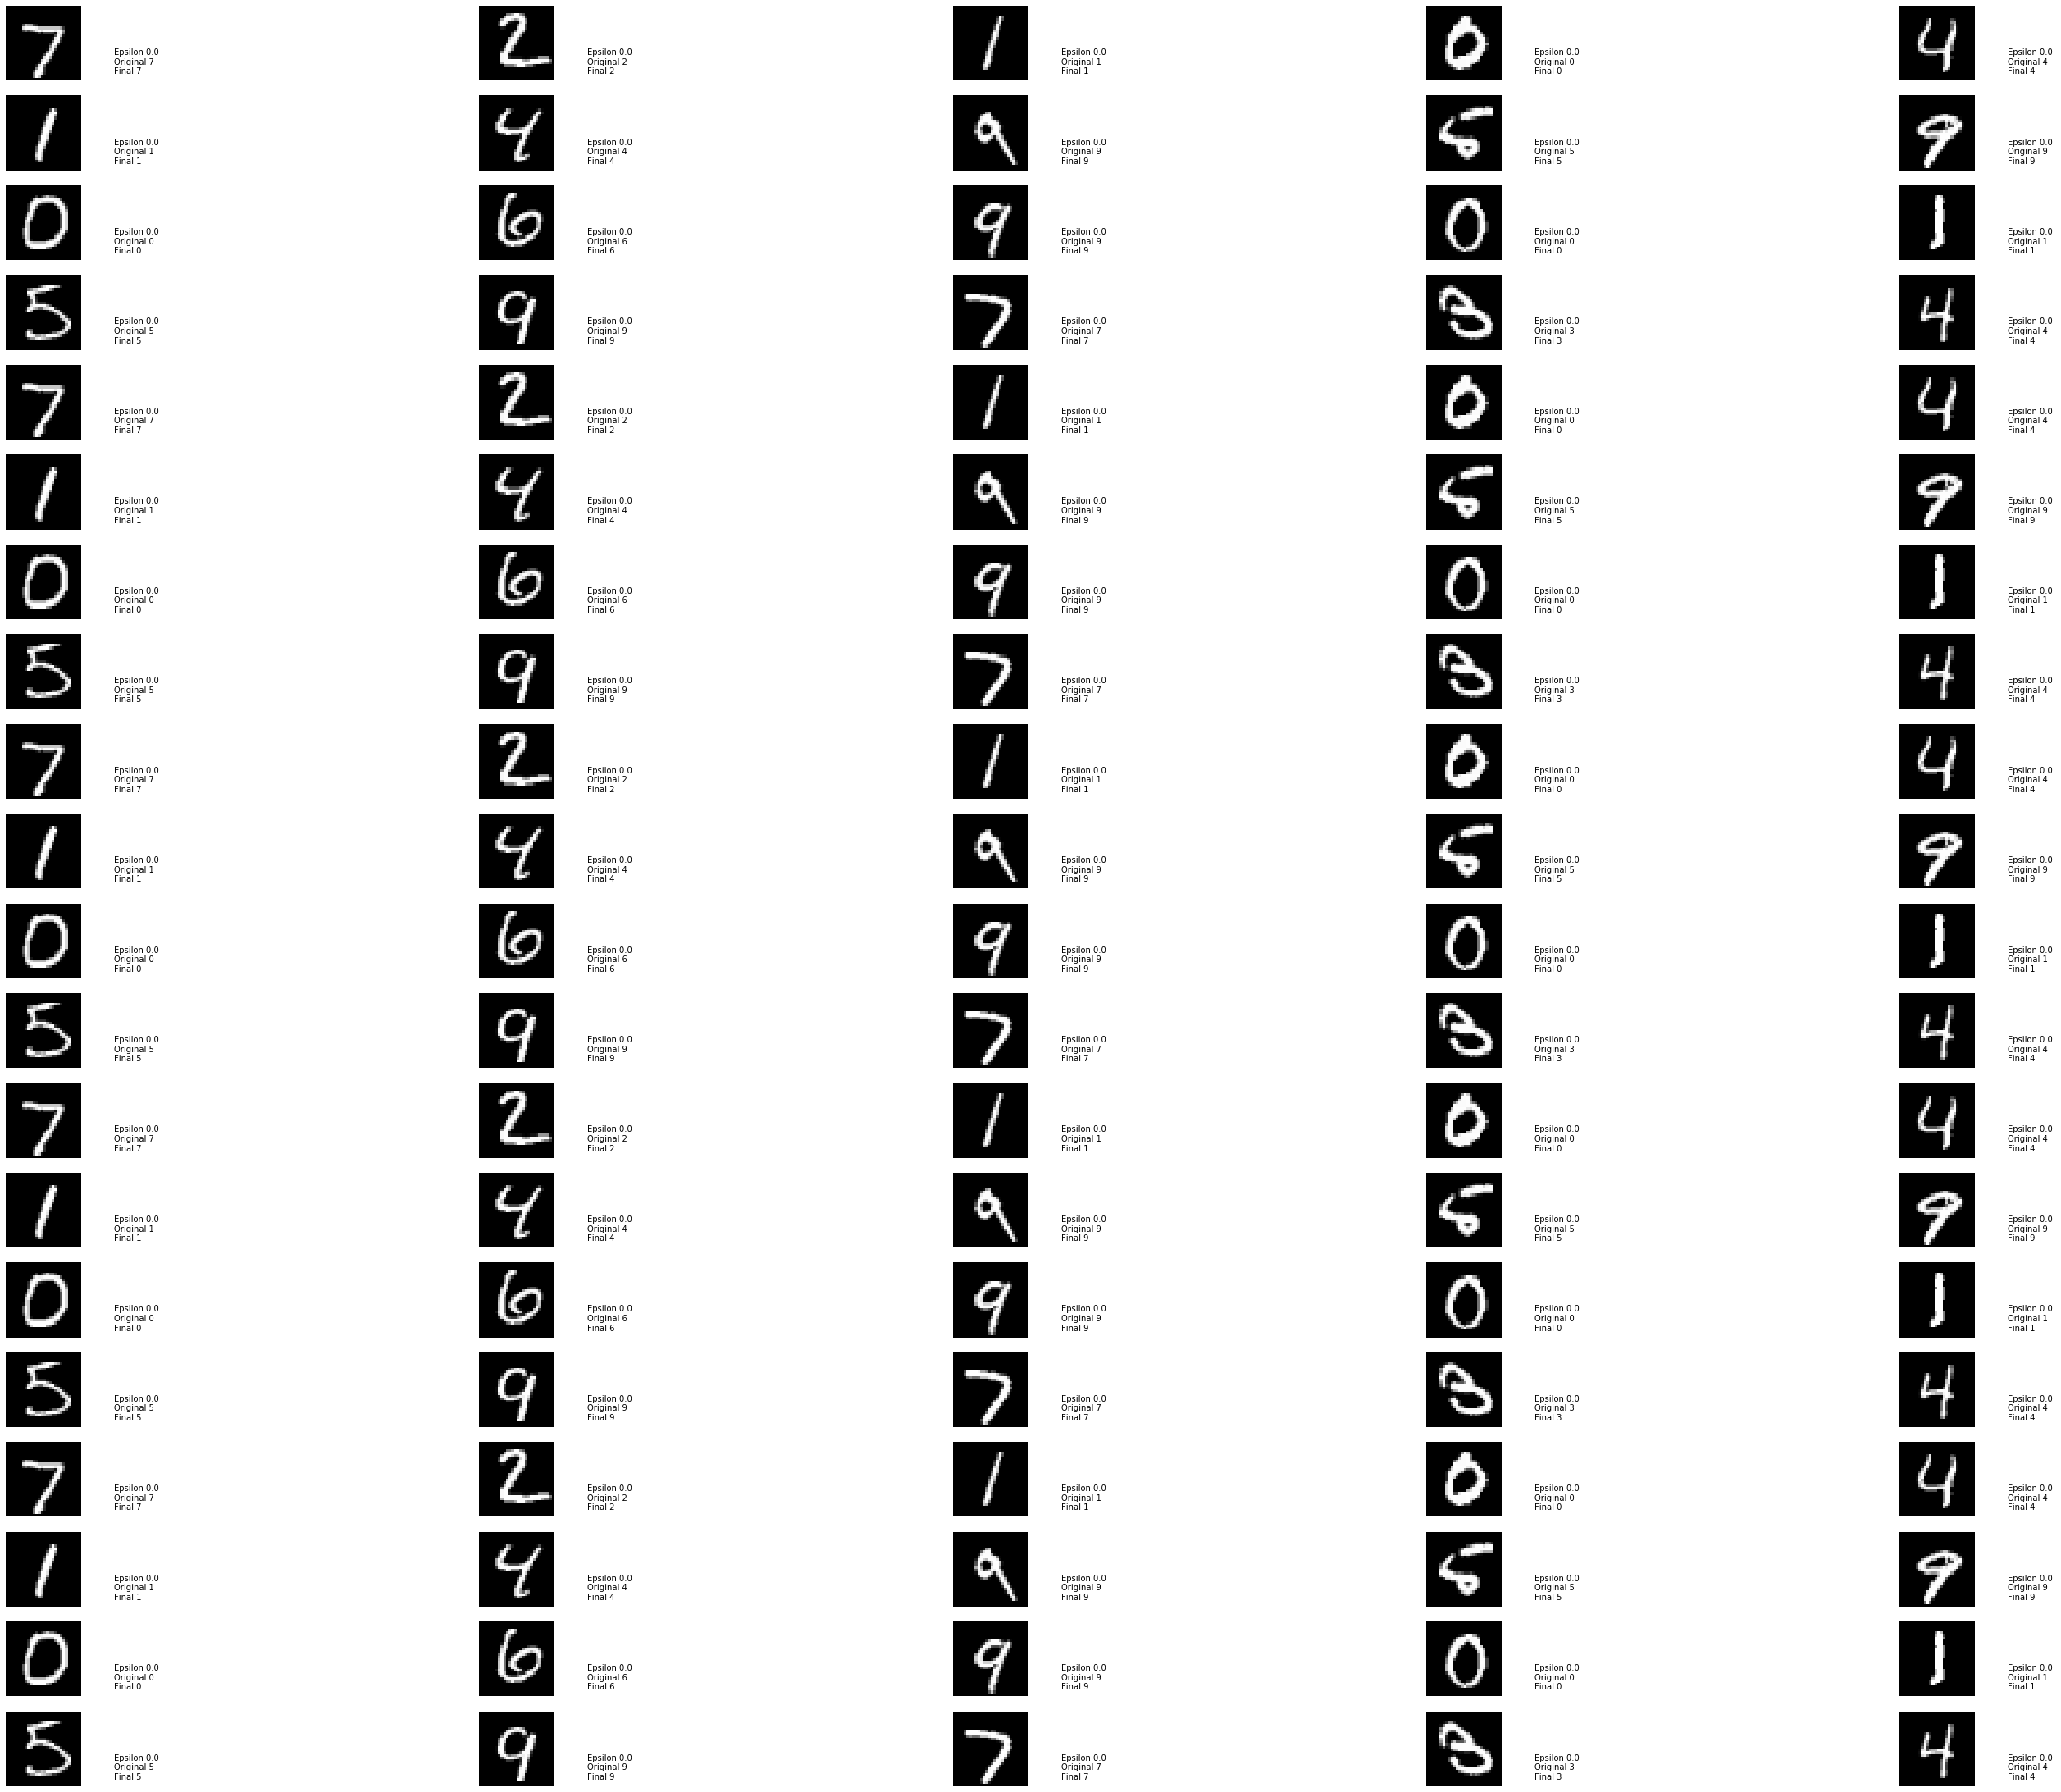

In [112]:
L2_collect(0,0)

In [27]:
L2_collect(0,1)

In [28]:
L2_collect(0,2)

In [29]:
L2_collect(0,3)

In [39]:
L2_collect(0,4)

In [40]:
L2_collect(0,5)

In [30]:
L2_collect(1,0)

In [31]:
L2_collect(1,1)

In [32]:
L2_collect(1,2)

In [33]:
L2_collect(1,3)

In [41]:
L2_collect(1,4)

In [44]:
L2_collect(1,5)

L2_collect(1,5)

L2_collect(1,5)

In [34]:
L2_collect(2,0)

In [35]:
L2_collect(2,1)

In [36]:
L2_collect(2,2)

In [37]:
L2_collect(2,3)

In [42]:
L2_collect(2,4)

In [43]:
L2_collect(2,5)

In [45]:
L2_norm_array=np.array(L2_norm).reshape((3,6))
avg_time = np.array(attack_time).reshape((3,1))

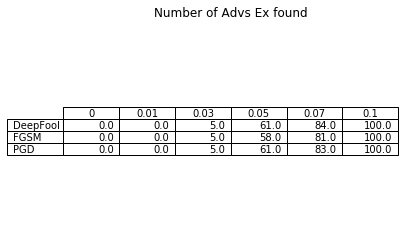

In [46]:
plt.axis("off")
plt.title("Number of Advs Ex found")
plt.table(cellText = (advs_success*100).round(), rowLabels = ("DeepFool", "FGSM", "PGD"), colLabels = ("0", "0.01", "0.03", "0.05", "0.07", "0.1"), loc = 'center')

plt.show()
#The top row is the epsilon value

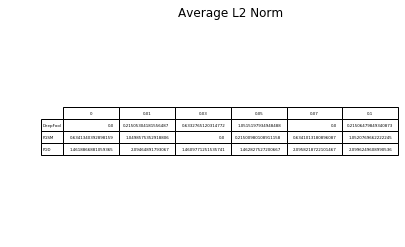

In [47]:
plt.axis("off")
plt.title("Average L2 Norm")
tables2 = plt.table(cellText = L2_norm_array, rowLabels = ("DeepFool", "FGSM", "PGD"), colLabels = ("0", "0.01", "0.03", "0.05", "0.07", "0.1"), loc = 'center')
plt.show()

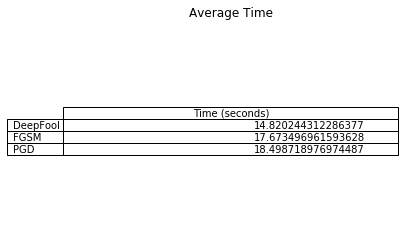

In [48]:
plt.axis("off")
plt.title("Average Time")
tables3 = plt.table(cellText = avg_time, rowLabels = ("DeepFool", "FGSM", "PGD"), colLabels = ("Time (seconds)",), loc = 'center')                      
plt.show()

In [ ]:
#I would recommend the Deel Fool attack because it is faster than the other attacks and performs just as well